In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

In [15]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score

In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [ ]:
np.random.seed(3)

# NB : les mask sont en nuance de gris ici

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)


def create_grayscale_mask(anns, borders=True):
    """Crée une image noire avec les masques en niveaux de gris"""
    if len(anns) == 0:
        return None
    
    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    h, w = sorted_anns[0]['segmentation'].shape
    
    # Image noire RGBA (canal alpha pour la transparence)
    mask_image = np.zeros((h, w, 4))
    mask_image[..., 3] = 1  # Fond noir opaque
    
    # Calcul des niveaux de gris
    n_masks = len(sorted_anns)
    gray_levels = np.linspace(0.2, 0.8, n_masks)  # Évite le blanc pur et le noir pur
    
    for i, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        gris = gray_levels[i]
        
        # Application du niveau de gris
        mask_image[m, :3] = gris  # Canal alpha reste à 1
        
        # Contours blancs semi-transparents
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), 
                                      cv2.RETR_EXTERNAL, 
                                      cv2.CHAIN_APPROX_NONE)
            contours = [cv2.approxPolyDP(c, 0.01, True) for c in contours]
            cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.4), 1)
    
    return mask_image

def filter_masks_by_color_sam2(image_rgb, sam_result, hue_range=(130, 160), min_masks=2, sat_threshold=40):
    """
    Version améliorée pour SAM2 avec :
    - Gestion native de l'espace colorimétrique RGB
    - Filtrage supplémentaire par saturation
    - Regroupement intelligent des teintes circulaires
    """
    # Conversion vers HSV depuis RGB
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
    features = []
    valid_masks = []

    # Pré-filtrage par saturation
    for mask_data in sam_result:
        mask = mask_data['segmentation']
        mean_sat = np.mean(hsv[mask, 1])
        if mean_sat > sat_threshold:
            valid_masks.append(mask_data)
            mean_hue = np.mean(hsv[mask, 0])
            features.append([mean_hue])

    if not valid_masks:
        return []

    # Adaptation pour la circularité des teintes (0-180 dans OpenCV)
    features = np.array(features)
    features_rad = np.deg2rad(features * 2)  # Conversion en radians [0-360°]
    features_circ = np.column_stack([np.sin(features_rad), np.cos(features_rad)])

    # Clustering avec K-means amélioré
    kmeans = KMeans(n_clusters=2, n_init=10, random_state=0).fit(features_circ)
    
    # Calcul des centroïdes en teinte réelle
    centroids_rad = np.arctan2(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])
    centroids_deg = np.rad2deg(centroids_rad) % 180

    # Sélection du cluster cible
    target_hue = np.mean(hue_range)
    hue_distances = np.abs(centroids_deg - target_hue)
    violet_cluster = np.argmin(hue_distances)

    filtered = [valid_masks[i] for i, label in enumerate(kmeans.labels_) if label == violet_cluster]

    # Sélection des masques les plus pertinents
    if len(filtered) < min_masks:
        hue_scores = 1 - np.abs(features[:,0] - target_hue)/180
        best_indices = np.argsort(hue_scores)[-min_masks:]
        filtered = [valid_masks[i] for i in best_indices]

    return filtered

def create_grayscale_mask_sam2(sam_masks, image_shape, border_size=2):
    """
    Version optimisée pour SAM2 :
    - Génération de masques vectoriels
    - Contours anticrénelés
    - Niveaux de gris adaptatifs
    """
    grayscale_image = np.zeros(image_shape[:2], dtype=np.uint8)
    sorted_masks = sorted(sam_masks, key=lambda x: x['area'], reverse=True)
    
    # Calcul dynamique des niveaux de gris
    n_masks = len(sorted_masks)
    gray_levels = np.linspace(50, 250, n_masks, dtype=np.uint8)
    
    for idx, mask_data in enumerate(sorted_masks):
        mask = mask_data['segmentation']
        
        # Dessin du masque principal
        grayscale_image[mask] = gray_levels[idx]
        
        # Ajout des bordures
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(grayscale_image, contours, -1, 255, border_size)
    
    # Post-traitement pour lisser les contours
    return cv2.medianBlur(grayscale_image, 3)    

## Example image

In [ ]:
image_Number = "00225"
image = Image.open(f"../../data/unified_set_rename/images/cell_{image_Number}.png")
imageSoluce = Image.open(f"../../data/unified_set_rename/labels/cell_{image_Number}_label.tiff")
image = np.array(image.convert("RGB"))
imageSoluce = np.array(imageSoluce.convert("RGB"))


## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [8]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../models/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

c:\Users\souro\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


To generate masks, just run `generate` on an image.

In [9]:
masks = mask_generator.generate(image)

c:\Users\souro\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [10]:
filtered_masks = filter_masks_by_color_sam2(
    image,
    masks,
    hue_range=(120, 170),  # De bleu sombre (120) à violet (170)
    sat_threshold=30,      # Seuil de saturation plus bas pour inclusions
    min_masks=3            # Garantie d'au moins 3 masques
)
grayscale_mask = create_grayscale_mask_sam2(filtered_masks, image.shape) 

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [11]:
print(len(masks))
print(masks[0].keys())

6
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

In [12]:
"""
plt.figure(figsize=(4, 4))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 
"""

"\nplt.figure(figsize=(4, 4))\nplt.imshow(image)\nshow_anns(masks)\nplt.axis('off')\nplt.show() \n"

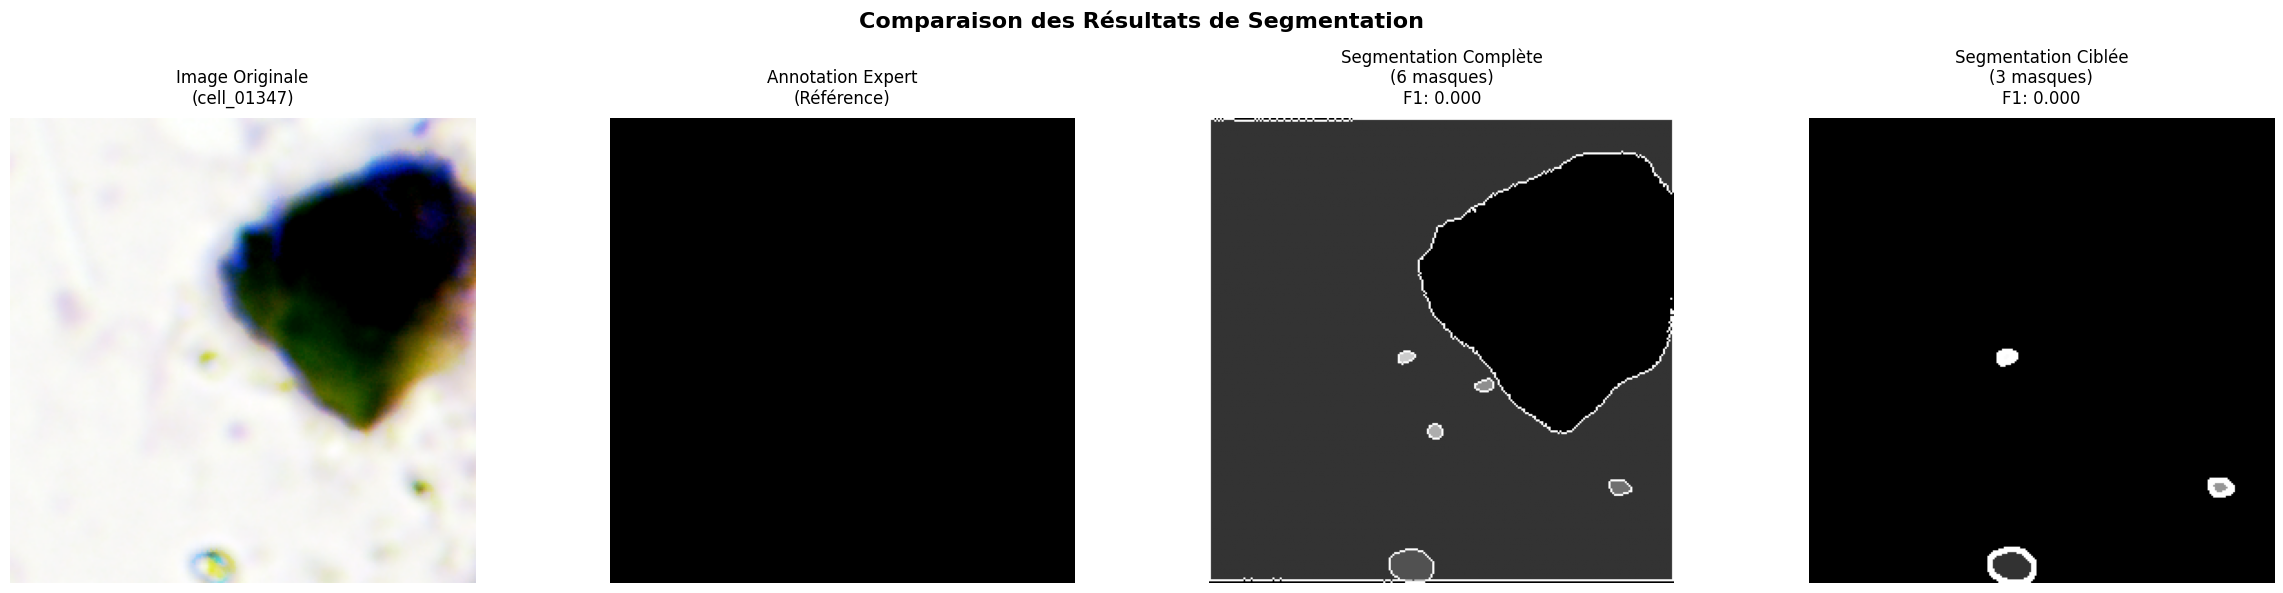

In [16]:
# --- Préparation des masques pour le calcul des métriques ---
def prepare_mask(mask):
    # Si le masque est multicanal (RGB ou RGBA), le convertir en binaire 2D
    if len(mask.shape) > 2:
        # Soit prendre un seul canal
        if mask.shape[2] == 3:  # RGB
            # Convertir RGB en niveau de gris puis en binaire
            gray_mask = np.mean(mask, axis=2)
        elif mask.shape[2] == 4:  # RGBA
            # Ignorer le canal alpha et convertir RGB en niveau de gris
            gray_mask = np.mean(mask[:, :, :3], axis=2)
        else:
            gray_mask = mask[:, :, 0]  # Prendre le premier canal
        # Binariser
        return gray_mask > 0
    else:
        # Déjà en 2D
        return mask > 0

def calculate_f1(mask1, mask2):
    mask1_bin = prepare_mask(mask1)
    mask2_bin = prepare_mask(mask2)
    return f1_score(mask1_bin.flatten(), mask2_bin.flatten())

# --- Affichage des résultats ---
plt.figure(figsize=(24, 6))

# Image originale
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title(f'Image Originale\n(cell_{image_Number})', fontsize=12, pad=10)
plt.axis('off')

# Vérité terrain (annotation expert)
plt.subplot(1, 4, 2)
plt.imshow(imageSoluce)
plt.title('Annotation Expert\n(Référence)', fontsize=12, pad=10)
plt.axis('off')

# Tous les masques SAM2
plt.subplot(1, 4, 3)
all_masks_display = create_grayscale_mask(masks) if len(masks) > 0 else np.zeros_like(image)

# Calcul du F1 score avec les masques préparés
f1_all = calculate_f1(imageSoluce, all_masks_display)

plt.imshow(all_masks_display if all_masks_display is not None else np.zeros_like(image))
plt.title(f'Segmentation Complète\n({len(masks)} masques)\nF1: {f1_all:.3f}',
          fontsize=12, pad=10)
plt.axis('off')

# Masques filtrés
plt.subplot(1, 4, 4)
if len(filtered_masks) > 0:
    filtered_display = create_grayscale_mask_sam2(filtered_masks, image.shape)

    # Calcul du F1 score avec les masques préparés
    f1_filtered = calculate_f1(imageSoluce, filtered_display)

    plt.imshow(filtered_display, cmap='gray', vmin=0, vmax=255)
    plt.title(f'Segmentation Ciblée\n({len(filtered_masks)} masques)\nF1: {f1_filtered:.3f}',
              fontsize=12, pad=10)
else:
    plt.imshow(np.zeros_like(image))
    plt.title(f'Segmentation Ciblée\n(0 masques)\nF1: 0.000',
              fontsize=12, pad=10)
plt.axis('off')

# Ajustements et affichage
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, top=0.8)
plt.suptitle('Comparaison des Résultats de Segmentation', y=0.98, fontsize=16, weight='bold')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [14]:
"""mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)"""

# masks2 = mask_generator_2.generate(image)
# plt.figure(figsize=(20, 20))
# plt.imshow(image)
# show_anns(masks2)
# plt.axis('off')
# plt.show() 

'mask_generator_2 = SAM2AutomaticMaskGenerator(\n    model=sam2,\n    points_per_side=64,\n    points_per_batch=128,\n    pred_iou_thresh=0.7,\n    stability_score_thresh=0.92,\n    stability_score_offset=0.7,\n    crop_n_layers=1,\n    box_nms_thresh=0.7,\n    crop_n_points_downscale_factor=2,\n    min_mask_region_area=25.0,\n    use_m2m=True,\n)'